In [1]:
import numpy as np
from tqdm import tqdm
import os

from videograph import VideoGraph
from utils.general import *
from utils.video_processing import *
from utils.chat_api import *
from prompts import *

from face_processing import process_faces
from voice_processing import process_voices
from memory_processing import (
    process_captions,
    generate_captions_and_thinkings_with_ids,
)

/usr/local/lib/python3.9/dist-packages/bytedtrace/__init__.py:108: UserWarning: [bytedtrace] global tracer is already initialized.
  warnings.warn('[bytedtrace] global tracer is already initialized.')


In [2]:
def process_segment(video_graph, base64_video, base64_frames, base64_audio):

    id2voices = process_voices(video_graph, base64_audio, base64_video)
    print("Finish processing voices")

    print(f"processing {len(base64_frames)} frames...")

    id2faces = process_faces(video_graph, base64_frames)
    # print(id2faces.keys())
    print("Finish processing faces")

    episodic_captions, semantic_captions = generate_captions_and_thinkings_with_ids(
        base64_video,
        base64_frames,
        base64_audio,
        id2faces,
        id2voices,
    )

    process_captions(video_graph, episodic_captions, type="episodic")
    process_captions(video_graph, semantic_captions, type="semantic")

    print("Finish processing segment")


def streaming_process_video(
    video_graph, video_path, interval_seconds, fps, segment_limit=None
):
    """Process video segments at specified intervals with given fps.

    Args:
        video_graph (VideoGraph): Graph object to store video information
        video_path (str): Path to the video file or directory containing clips
        interval_seconds (float): Time interval between segments in seconds
        fps (float): Frames per second to extract from each segment

    Returns:
        None: Updates video_graph in place with processed segments
    """
    if os.path.isfile(video_path):
        # Process single video file
        video_info = get_video_info(video_path)
        print(video_info)

        # Process each interval
        count = 0
        for start_time in np.arange(0, video_info["duration"], interval_seconds):
            if start_time + interval_seconds > video_info["duration"]:
                break

            print("=" * 20)
            count += 1

            print(f"Loading {count}-th clip starting at {start_time} seconds...")
            base64_video, base64_frames, base64_audio = process_video_clip(
                video_path, start_time, interval_seconds, fps, audio_format="wav"
            )

            # check dtype
            # print(type(base64_video), type(base64_frames[0]), type(base64_audio))

            # Process frames for this interval
            if base64_frames:
                print(
                    f"Starting processing {count}-th clip starting at {start_time} seconds..."
                )
                process_segment(
                    video_graph,
                    base64_video,
                    base64_frames,
                    base64_audio,
                )

            if segment_limit is not None and count >= segment_limit:
                break

    elif os.path.isdir(video_path):
        # Process directory of numbered clips
        files = os.listdir(video_path)
        # Filter for video files and sort by numeric value in filename
        video_files = [
            f for f in files if any(f.endswith(ext) for ext in [".mp4", ".avi", ".mov"])
        ]
        video_files.sort(key=lambda x: int("".join(filter(str.isdigit, x))))

        for count, video_file in enumerate(video_files, 1):
            print("=" * 20)
            full_path = os.path.join(video_path, video_file)
            print(f"Processing clip {count}: {full_path}")

            base64_video, base64_frames, base64_audio = process_video_clip(
                full_path, 0, interval_seconds, fps, audio_format="wav"
            )

            if base64_frames:
                process_segment(
                    video_graph,
                    base64_video,
                    base64_frames,
                    base64_audio,
                )

            if segment_limit is not None and count >= segment_limit:
                break

Processing clip 1: data/videos/clipped/5 Poor People vs 1 Secret Millionaire/1.mp4
{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 1044, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 129, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 30.0, 'bitrate': 1179, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 1044, 'fps': 23.976023976023978, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 129, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 30.0, 'bitrate': 1179, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [1280, 720], 'video_bitrate': 1044, 'video

2025-03-25 04:58:49,234 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:03', 'asr': "We got Denny, Herm, Aaron, and JC and five people who say they're millionaires,", 'duration': 3}, {'start_time': '00:05', 'end_time': '00:08', 'asr': "but only one of them is, and the other four are lying. Let's just start by just appearances.", 'duration': 3}, {'start_time': '00:10', 'end_time': '00:11', 'asr': 'Okay.', 'duration': 1}, {'start_time': '00:11', 'end_time': '00:11', 'asr': "You're broke.", 'duration': 0}, {'start_time': '00:12', 'end_time': '00:13', 'asr': 'I heard that before.', 'duration': 1}, {'start_time': '00:13', 'end_time': '00:15', 'asr': 'Got bills.', 'duration': 2}, {'start_time': '00:15', 'end_time': '00:15', 'asr': 'Got bills.', 'duration': 0}, {'start_time': '00:15', 'end_time': '00:16', 'asr': '100%.', 'duration': 1}, {'start_time': '00:16', 'end_time': '00:18', 'asr': "That's not right. That's not right, bro.", 'duration': 2}, {'start_time': '00:18', 'end_time': '00:21', 'asr': "Because you wasn't a gue

100%|██████████| 150/150 [00:37<00:00,  4.00it/s]


Image node added with ID 3
Image node added with ID 4
Image node added with ID 5
Image node added with ID 6
Image node added with ID 7
Image node added with ID 8
Image node added with ID 9
Image node added with ID 10
Image node added with ID 11
Finish processing faces
id num: 8


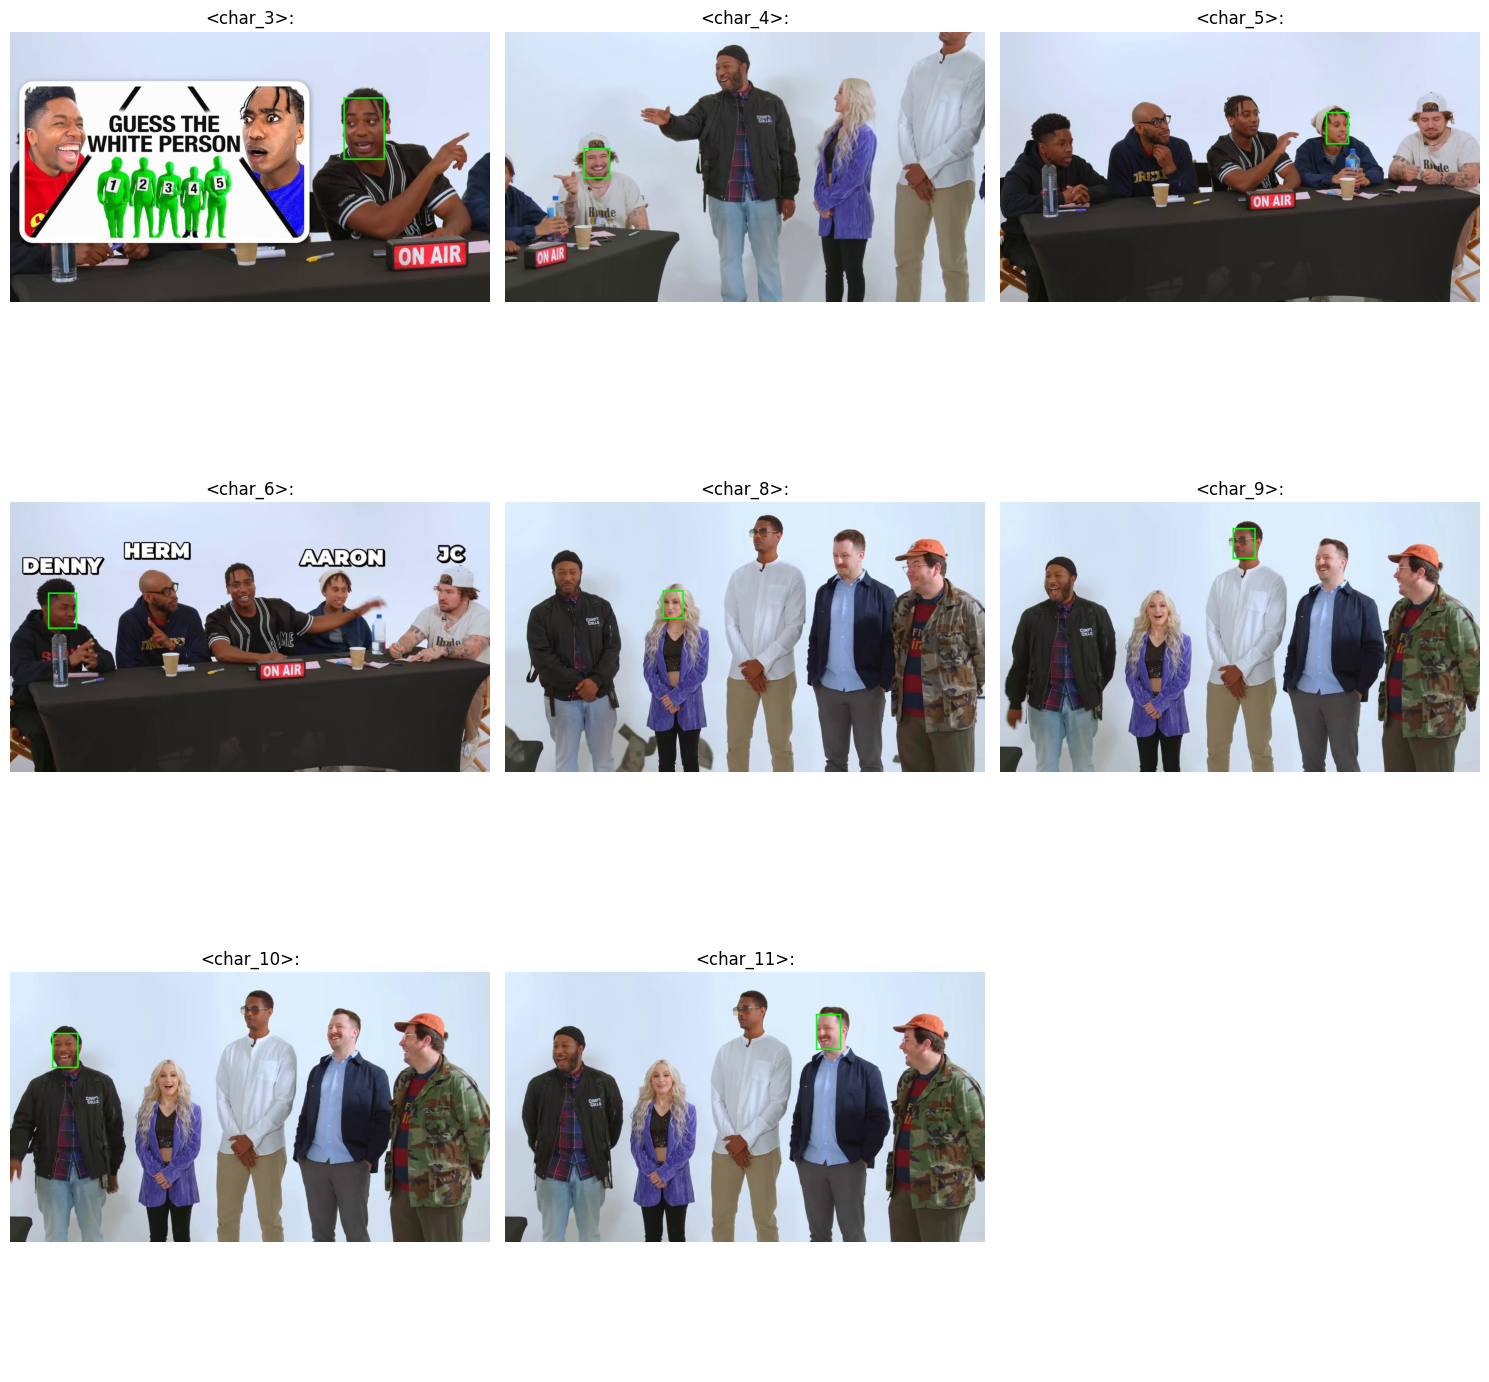

{'<speaker_0>': [{'start_time': '00:00', 'end_time': '00:03', 'content': "We got Denny, Herm, Aaron, and JC and five people who say they're millionaires,"}, {'start_time': '00:05', 'end_time': '00:08', 'content': "but only one of them is, and the other four are lying. Let's just start by just appearances."}], '<speaker_1>': [{'start_time': '00:13', 'end_time': '00:15', 'content': 'Got bills.'}], '<speaker_2>': [{'start_time': '00:18', 'end_time': '00:21', 'content': "Because you wasn't a guest of black prison, and I think we had to pay him."}, {'start_time': '00:21', 'end_time': '00:24', 'content': 'Number five, your shoes are elite.'}, {'start_time': '00:26', 'end_time': '00:29', 'content': 'that means Yes. very comfortable with'}, {'start_time': '00:16', 'end_time': '00:18', 'content': "That's not right. That's not right, bro."}]}
Generating captions 0 times


2025-03-25 04:59:39,083 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


Generating thinkings 0 times


2025-03-25 04:59:43,934 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


['<char_6> wears a black hoodie with red and white lettering.', '<char_6> sits at a table with his hands clasped.', '<char_7> wears glasses and a dark blue Drexel sweatshirt.', '<char_7> sits at a table with his hand on his chin.', '<char_3> wears a white and black baseball jersey.', '<char_3> raises his right hand and speaks.', '<char_5> wears a light blue denim jacket and a beanie.', '<char_5> holds a plastic water bottle in his right hand.', '<char_4> wears a white t-shirt with “Rude” written across the front.', '<char_4> gives a thumbs up sign.', '<char_10> wears a black bomber jacket with a red and white plaid shirt underneath.', '<char_10> points with his right hand.', "<speaker_1> (represented by <char_10>) says: 'You're broke'.", '<char_9> wears a white band collar shirt and tan pants.', '<char_9> wears sunglasses.', '<char_8> wears a purple blazer over a sparkly top and black pants.', '<char_8> covers her mouth with her right hand and laughs.', '<char_11> wears a blue collared

2025-03-25 05:00:12,287 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:05', 'asr': "Means he got a lot of money. And he got penny loafers on with no penny in it. So, it's like y'all don't even know how much I got. You know what I'm saying?", 'duration': 5}, {'start_time': '00:06', 'end_time': '00:07', 'asr': 'So a lot.', 'duration': 1}, {'start_time': '00:07', 'end_time': '00:10', 'asr': "But, then again, millionaires don't dress up.", 'duration': 3}, {'start_time': '00:10', 'end_time': '00:17', 'asr': "They really wear like, like four, three and four, very like calm, because they don't make, you know, they don't stress themselves out. You don't look like he's drifted that. He looks a little bit too well put together, I would say.", 'duration': 7}, {'start_time': '00:21', 'end_time': '00:25', 'asr': "You look like you're pretending that you have money, but you work at Gelsons.", 'duration': 4}, {'start_time': '00:26', 'end_time': '00:29', 'asr': "We're gazing over number two, our beautiful lady here. Are we?", 'dur

100%|██████████| 150/150 [00:34<00:00,  4.31it/s]


Embeddings added to node 11
Embeddings added to node 6
Embeddings added to node 4
Image node added with ID 42
Embeddings added to node 5
Embeddings added to node 3
Image node added with ID 43
Embeddings added to node 10
Image node added with ID 44
Embeddings added to node 9
Finish processing faces
id num: 8


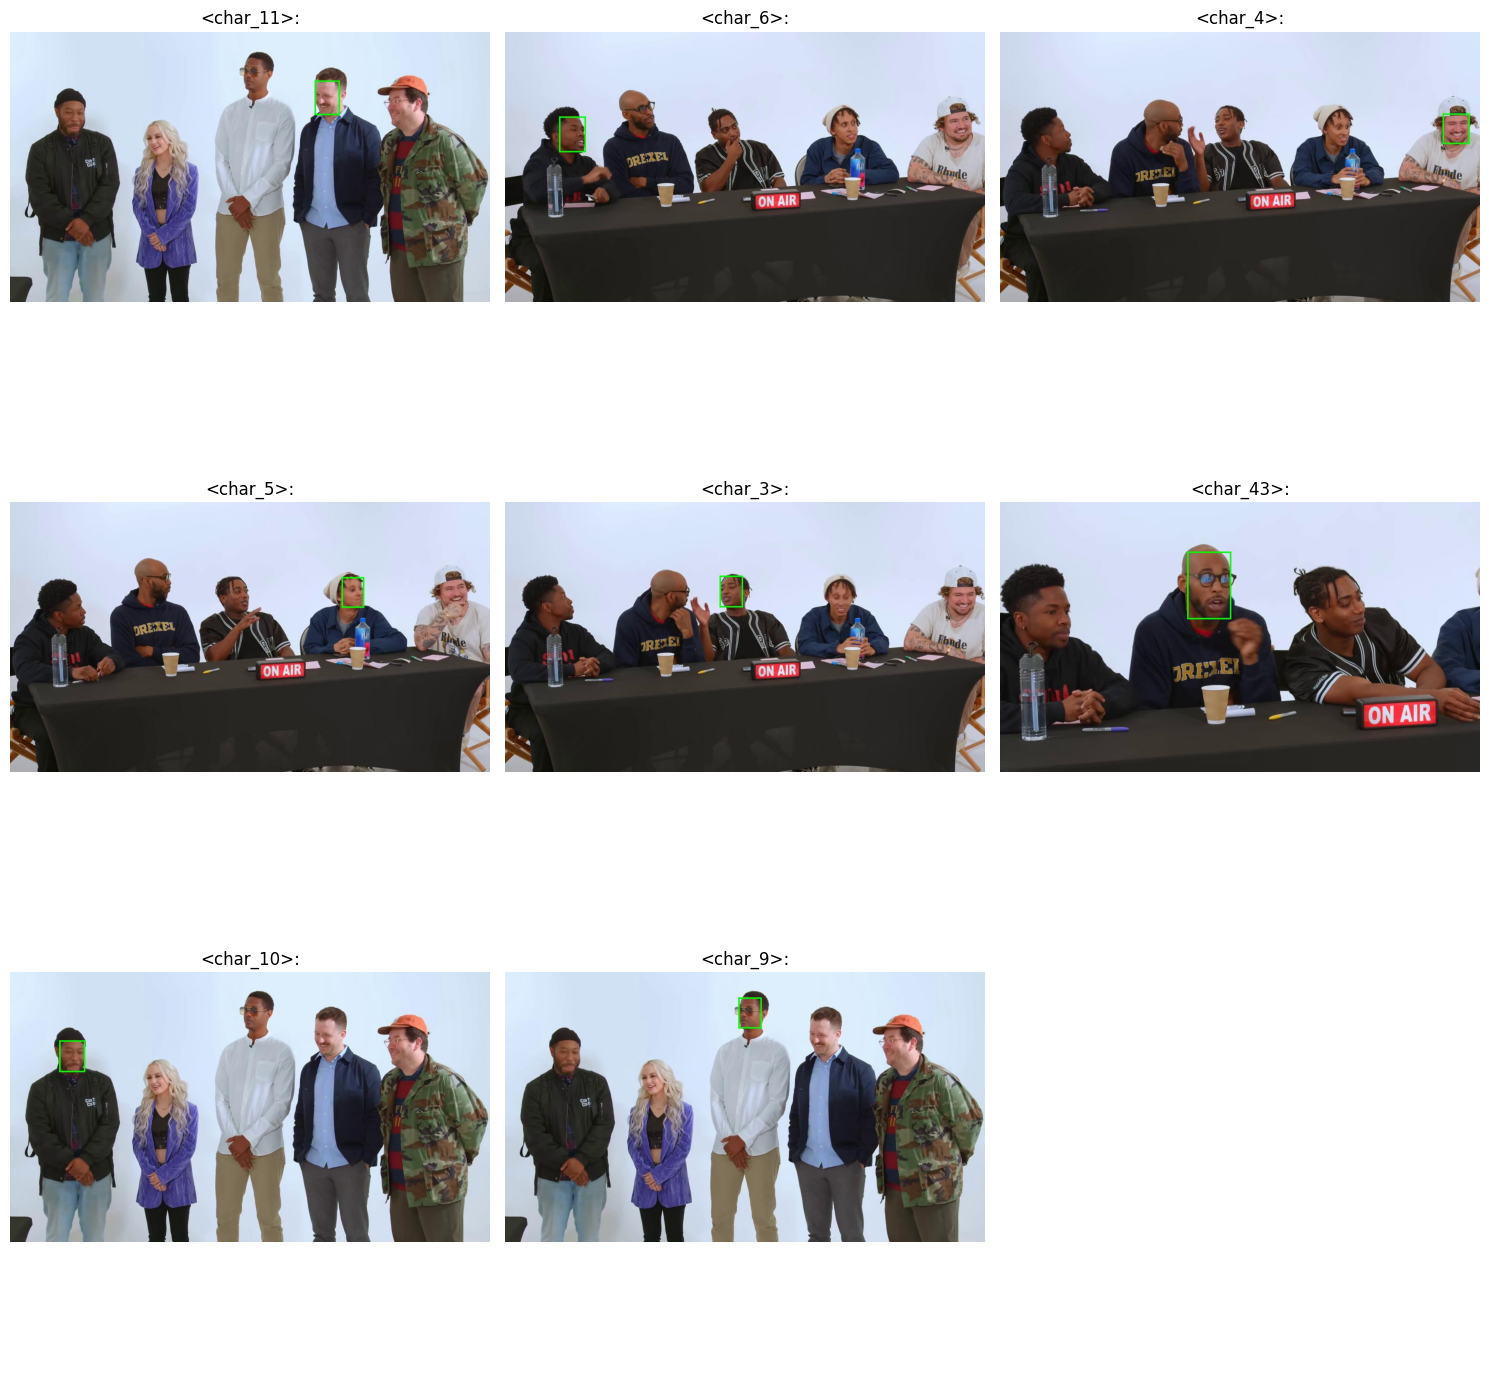

{'<speaker_2>': [{'start_time': '00:00', 'end_time': '00:05', 'content': "Means he got a lot of money. And he got penny loafers on with no penny in it. So, it's like y'all don't even know how much I got. You know what I'm saying?"}, {'start_time': '00:21', 'end_time': '00:25', 'content': "You look like you're pretending that you have money, but you work at Gelsons."}], '<speaker_0>': [{'start_time': '00:10', 'end_time': '00:17', 'content': "They really wear like, like four, three and four, very like calm, because they don't make, you know, they don't stress themselves out. You don't look like he's drifted that. He looks a little bit too well put together, I would say."}, {'start_time': '00:07', 'end_time': '00:10', 'content': "But, then again, millionaires don't dress up."}, {'start_time': '00:26', 'end_time': '00:29', 'content': "We're gazing over number two, our beautiful lady here. Are we?"}]}
Generating captions 0 times


2025-03-25 05:01:03,313 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


Generating thinkings 0 times


2025-03-25 05:01:06,775 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


['<char_43> wears a navy blue Drexel University hoodie.', '<char_43> sits at a table with arms crossed.', '<char_43> gestures with his hands while speaking.', "<speaker_2> (represented by <char_43>) says: 'Means he got a lot of money. And he got penny loafers on with no penny in it. So, it's like y'all don't even know how much I got. You know what I'm saying?'", '<char_3> wears a black and white baseball jersey.', '<char_3> sits at a table and gestures with his hands while speaking.', '<char_3> looks at the person standing opposite him.', "<speaker_0> (represented by <char_3>) says: 'They really wear like, like four, three and four, very like calm, because they don't make, you know, they don't stress themselves out. You don't look like he's drifted that.'", '<char_5> wears a denim jacket and white beanie.', '<char_5> holds a plastic water bottle.', '<char_5> smiles while looking at <char_3>.', "<speaker_0> (represented by <char_5>) says: 'But, then again, millionaires don't dress up.'"

2025-03-25 05:01:38,183 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:01', 'asr': 'Gazing?', 'duration': 1}, {'start_time': '00:01', 'end_time': '00:03', 'asr': "I feel like you're gazing?", 'duration': 2}, {'start_time': '00:03', 'end_time': '00:06', 'asr': 'No, I meant No, I meant No, I meant', 'duration': 3}, {'start_time': '00:07', 'end_time': '00:10', 'asr': "I just meant where What's the English word for when we're like not paying attention to?", 'duration': 3}, {'start_time': '00:10', 'end_time': '00:13', 'asr': "Oh, okay. You mean like we're We're overlooking", 'duration': 3}, {'start_time': '00:14', 'end_time': '00:20', 'asr': 'But, I will say this. You look very well put together. I like the sparkles. She look like she may have new money.', 'duration': 6}, {'start_time': '00:20', 'end_time': '00:26', 'asr': "We got to see you guys. Now, let's just dive into y'all one by one. So, number one, tell us your name and your job.", 'duration': 6}, {'start_time': '00:26', 'end_time': '00:29', 'asr': "My name is u

100%|██████████| 150/150 [00:37<00:00,  4.05it/s]


Embeddings added to node 9
Embeddings added to node 11
Embeddings added to node 43
Embeddings added to node 3
Embeddings added to node 5
Embeddings added to node 4
Embeddings added to node 6
Embeddings added to node 10
Finish processing faces
id num: 8


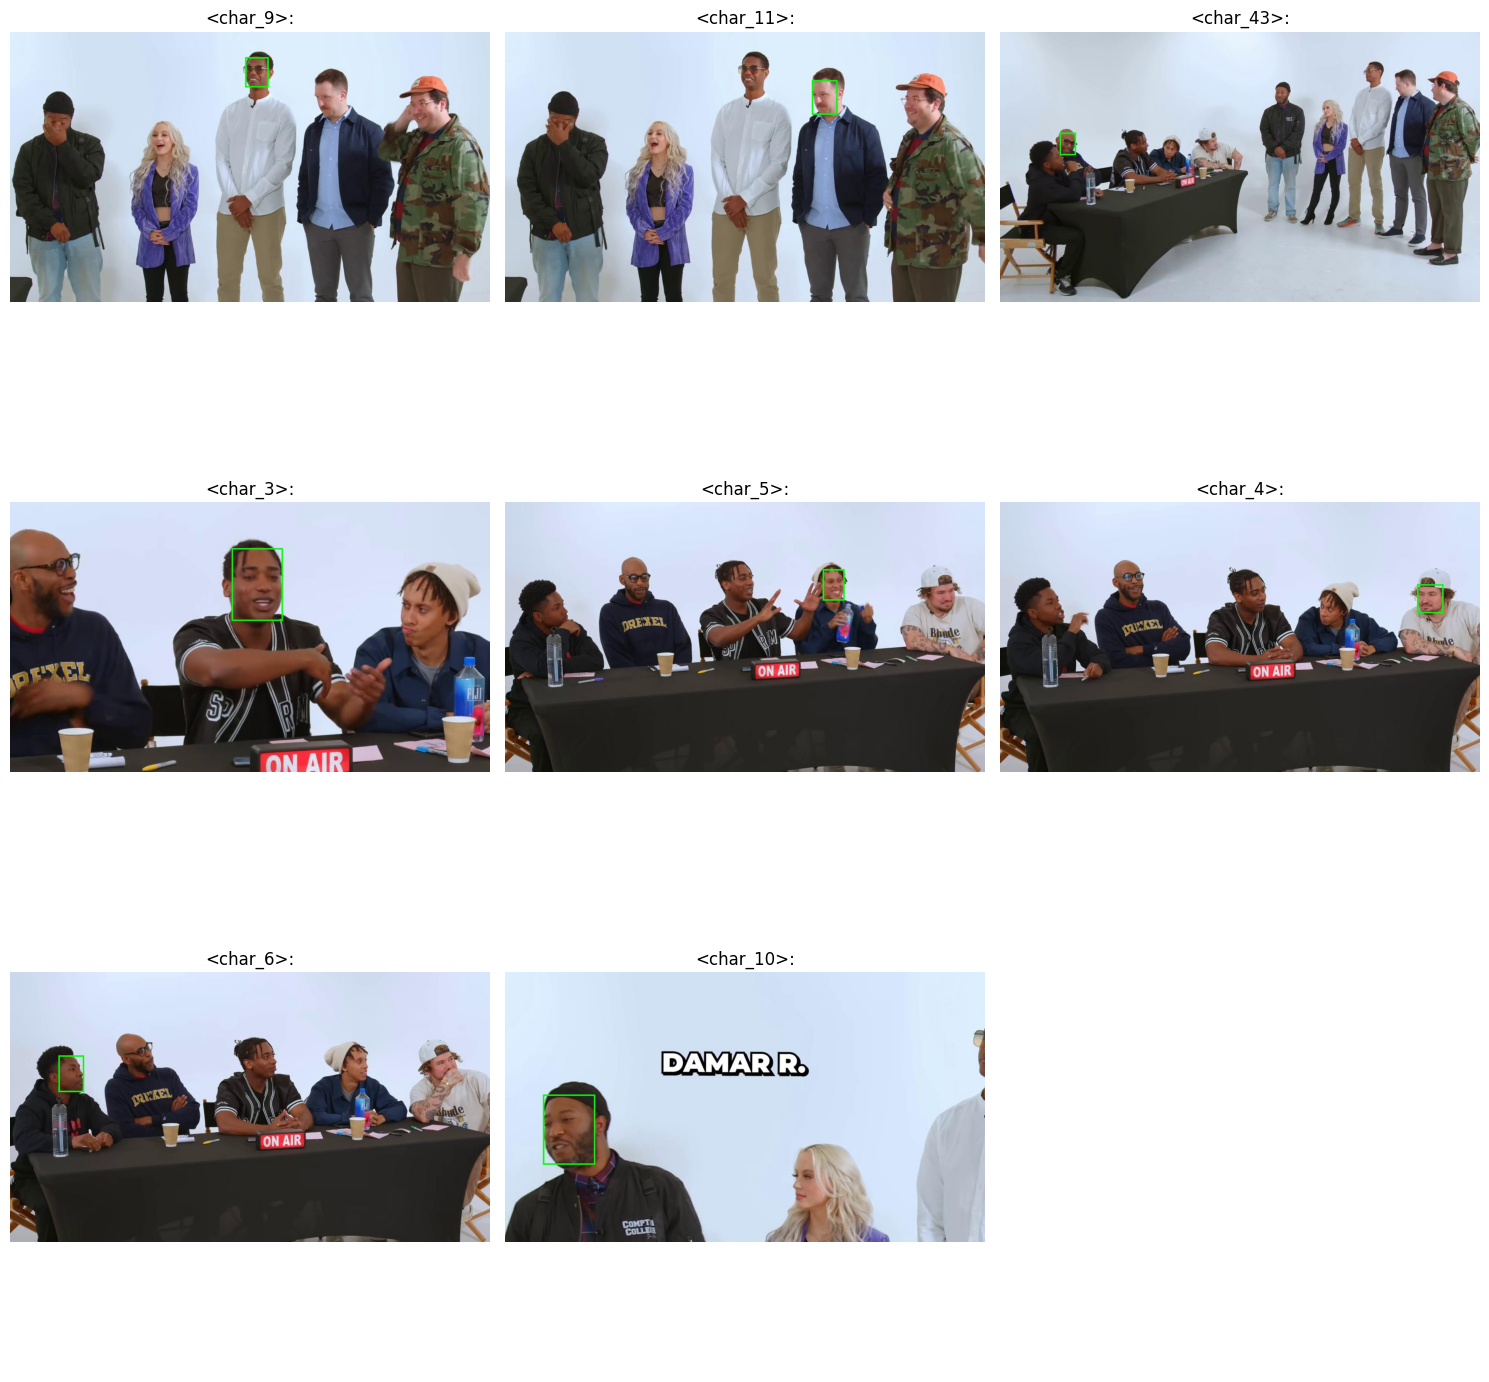

{'<speaker_80>': [{'start_time': '00:14', 'end_time': '00:20', 'content': 'But, I will say this. You look very well put together. I like the sparkles. She look like she may have new money.'}, {'start_time': '00:01', 'end_time': '00:03', 'content': "I feel like you're gazing?"}], '<speaker_81>': [{'start_time': '00:03', 'end_time': '00:06', 'content': 'No, I meant No, I meant No, I meant'}], '<speaker_0>': [{'start_time': '00:20', 'end_time': '00:26', 'content': "We got to see you guys. Now, let's just dive into y'all one by one. So, number one, tell us your name and your job."}, {'start_time': '00:07', 'end_time': '00:10', 'content': "I just meant where What's the English word for when we're like not paying attention to?"}, {'start_time': '00:10', 'end_time': '00:13', 'content': "Oh, okay. You mean like we're We're overlooking"}], '<speaker_2>': [{'start_time': '00:26', 'end_time': '00:29', 'content': "My name is uh, Demar Randy. And, uh, my job is uh, I'm a"}]}
Generating captions 0 t

2025-03-25 05:02:28,089 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


Generating thinkings 0 times


2025-03-25 05:02:34,754 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


['<char_10> wears a black jacket and a beanie.', '<char_10> laughs and covers his mouth with his hand.', "<speaker_2>: 'My name is uh, Demar Randy. And, uh, my job is uh, I'm a'", '<char_9> wears a white long-sleeved shirt and khaki pants.', '<char_9> has sunglasses on.', '<char_9> stands with his arms crossed.', '<char_11> wears a gray jacket, dark-colored pants, and a light-colored shirt.', '<char_11> places his hand on his chin.', '<char_43> wears a camouflage jacket and brown loafers.', '<char_43> has short brown hair and wears glasses.', '<char_43> holds his head with one hand.', '<char_3> wears a black and white baseball jersey.', '<char_3> raises his hands in front of him while talking.', "<speaker_0>: 'I just meant where What's the English word for when we're like not paying attention to?'", '<char_5> wears a dark blue jacket and a beige beanie.', '<char_5> holds a blue water bottle in one hand.', '<char_5> claps his hands.', '<char_4> wears a light-colored t-shirt and a baseba

2025-03-25 05:03:04,975 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:00', 'end_time': '00:01', 'asr': 'fashion designer.', 'duration': 1}, {'start_time': '00:01', 'end_time': '00:02', 'asr': 'Oh, dope.', 'duration': 1}, {'start_time': '00:01', 'end_time': '00:02', 'asr': 'Wow.', 'duration': 1}, {'start_time': '00:02', 'end_time': '00:02', 'asr': "That's dope.", 'duration': 0}, {'start_time': '00:03', 'end_time': '00:05', 'asr': "Uh, I'm Tori K. and, uh, my family works in the oil business.", 'duration': 2}, {'start_time': '00:06', 'end_time': '00:07', 'asr': 'Oh my god!', 'duration': 1}, {'start_time': '00:08', 'end_time': '00:12', 'asr': 'She said her family. She said her family. She said her family.', 'duration': 4}, {'start_time': '00:13', 'end_time': '00:14', 'asr': 'Yeah, but why people share their wealth?', 'duration': 1}, {'start_time': '00:14', 'end_time': '00:15', 'asr': 'Facts.', 'duration': 1}, {'start_time': '00:15', 'end_time': '00:16', 'asr': 'Number three.', 'duration': 1}, {'start_time': '00:16', 'end_time': '00:18', 

100%|██████████| 150/150 [00:22<00:00,  6.75it/s]


Embeddings added to node 8
Embeddings added to node 10
Embeddings added to node 4
Embeddings added to node 5
Embeddings added to node 3
Embeddings added to node 6
Embeddings added to node 43
Embeddings added to node 9
Finish processing faces
id num: 8


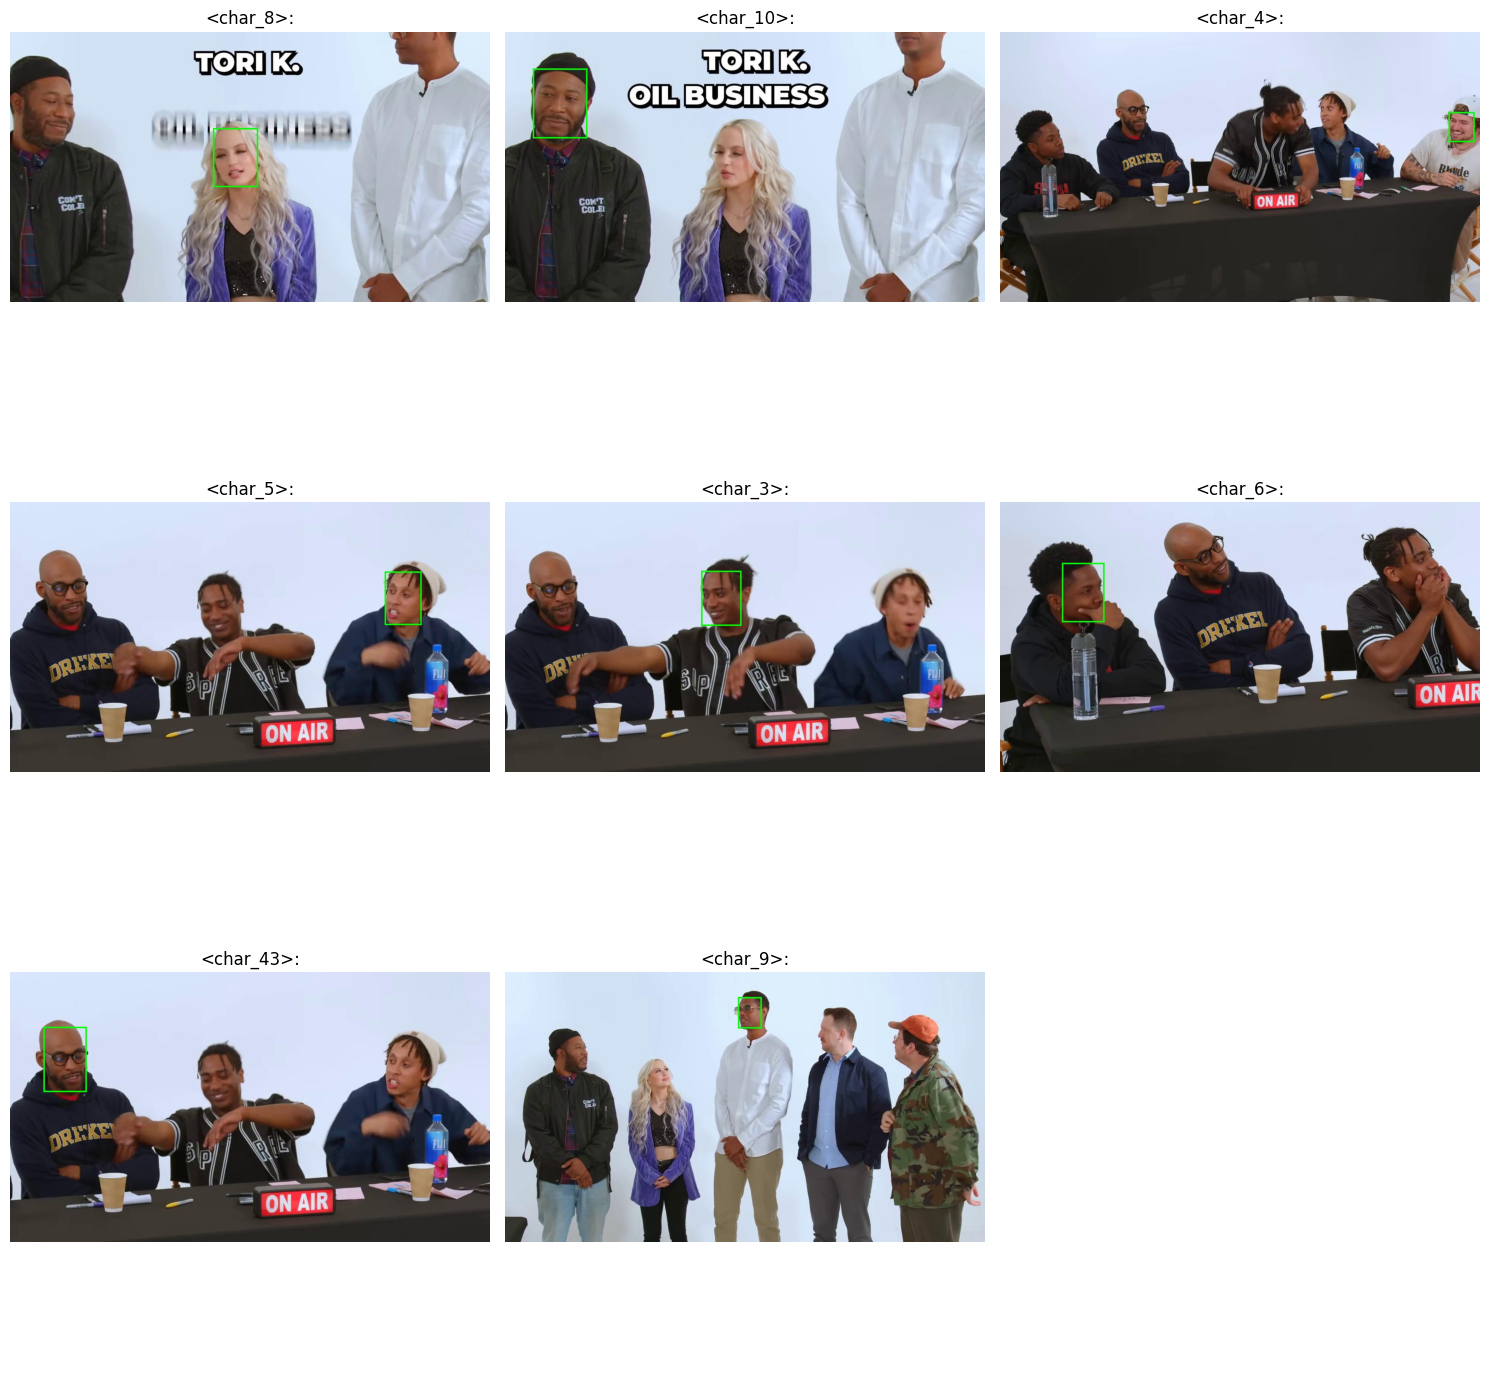

{'<speaker_120>': [{'start_time': '00:03', 'end_time': '00:05', 'content': "Uh, I'm Tori K. and, uh, my family works in the oil business."}], '<speaker_0>': [{'start_time': '00:08', 'end_time': '00:12', 'content': 'She said her family. She said her family. She said her family.'}, {'start_time': '00:18', 'end_time': '00:21', 'content': 'But, uh, I guess we about to find out now what you do and who you are. Who are you?'}], '<speaker_80>': [{'start_time': '00:26', 'end_time': '00:29', 'content': 'Hey, nah, this broke. This need a LaLone.'}, {'start_time': '00:16', 'end_time': '00:18', 'content': 'Look like an African prince.'}], '<speaker_121>': [{'start_time': '00:22', 'end_time': '00:24', 'content': 'My name is Labone James.'}]}
Generating captions 0 times


2025-03-25 05:03:39,558 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


Generating thinkings 0 times


2025-03-25 05:03:45,068 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


['<char_10> wears a black bomber jacket with a plaid shirt and jeans.', '<char_10> has a beard and wears a black beanie.', '<char_8> wears a purple blazer over a sequined crop top and black pants.', '<char_8> has long, wavy platinum blonde hair.', "<speaker_120> (represented by <char_8>) says: 'Uh, I'm Tori K. and, uh, my family works in the oil business.'", '<char_9> wears a white long-sleeved shirt and tan pants.', '<char_9> wears tinted aviator sunglasses.', "<speaker_121> (represented by <char_9>) says: 'My name is Labone James.'", '<char_6> wears a black hoodie with a white logo.', '<char_6> sits at a table with his hand on his chin.', '<char_43> wears a navy blue Drexel University hoodie.', '<char_43> sits with his arms crossed.', '<char_3> wears a black and white baseball jersey.', '<char_3> slams his hands down on the table.', '<char_5> wears a navy blue collared shirt and a tan beanie.', '<char_5> raises his index fingers.', '<char_4> wears a white t-shirt with a graphic and l

2025-03-25 05:08:29,572 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[{'start_time': '00:01', 'end_time': '00:02', 'asr': 'His teeth, bro.', 'duration': 1}, {'start_time': '00:03', 'end_time': '00:05', 'asr': 'What do you do for a living, Labone?', 'duration': 2}, {'start_time': '00:05', 'end_time': '00:08', 'asr': "Uh, I'm a creative.", 'duration': 3}, {'start_time': '00:08', 'end_time': '00:10', 'asr': 'Okay. He might be nice.', 'duration': 2}, {'start_time': '00:10', 'end_time': '00:11', 'asr': 'He might be broke.', 'duration': 1}, {'start_time': '00:11', 'end_time': '00:12', 'asr': 'Did you name yourself Labone?', 'duration': 1}, {'start_time': '00:12', 'end_time': '00:13', 'asr': 'He might', 'duration': 1}, {'start_time': '00:13', 'end_time': '00:16', 'asr': "Yeah, yeah, it's, uh, my OnlyFans handle, so.", 'duration': 3}, {'start_time': '00:16', 'end_time': '00:17', 'asr': 'Oh!', 'duration': 1}, {'start_time': '00:17', 'end_time': '00:19', 'asr': "We might have a millionaire. I don't even know.", 'duration': 2}, {'start_time': '00:20', 'end_time': 

100%|██████████| 150/150 [00:25<00:00,  5.78it/s]


Embeddings added to node 4
Embeddings added to node 5
Embeddings added to node 3
Embeddings added to node 43
Embeddings added to node 6
Embeddings added to node 9
Embeddings added to node 10
Embeddings added to node 8
Embeddings added to node 11
Finish processing faces
id num: 9


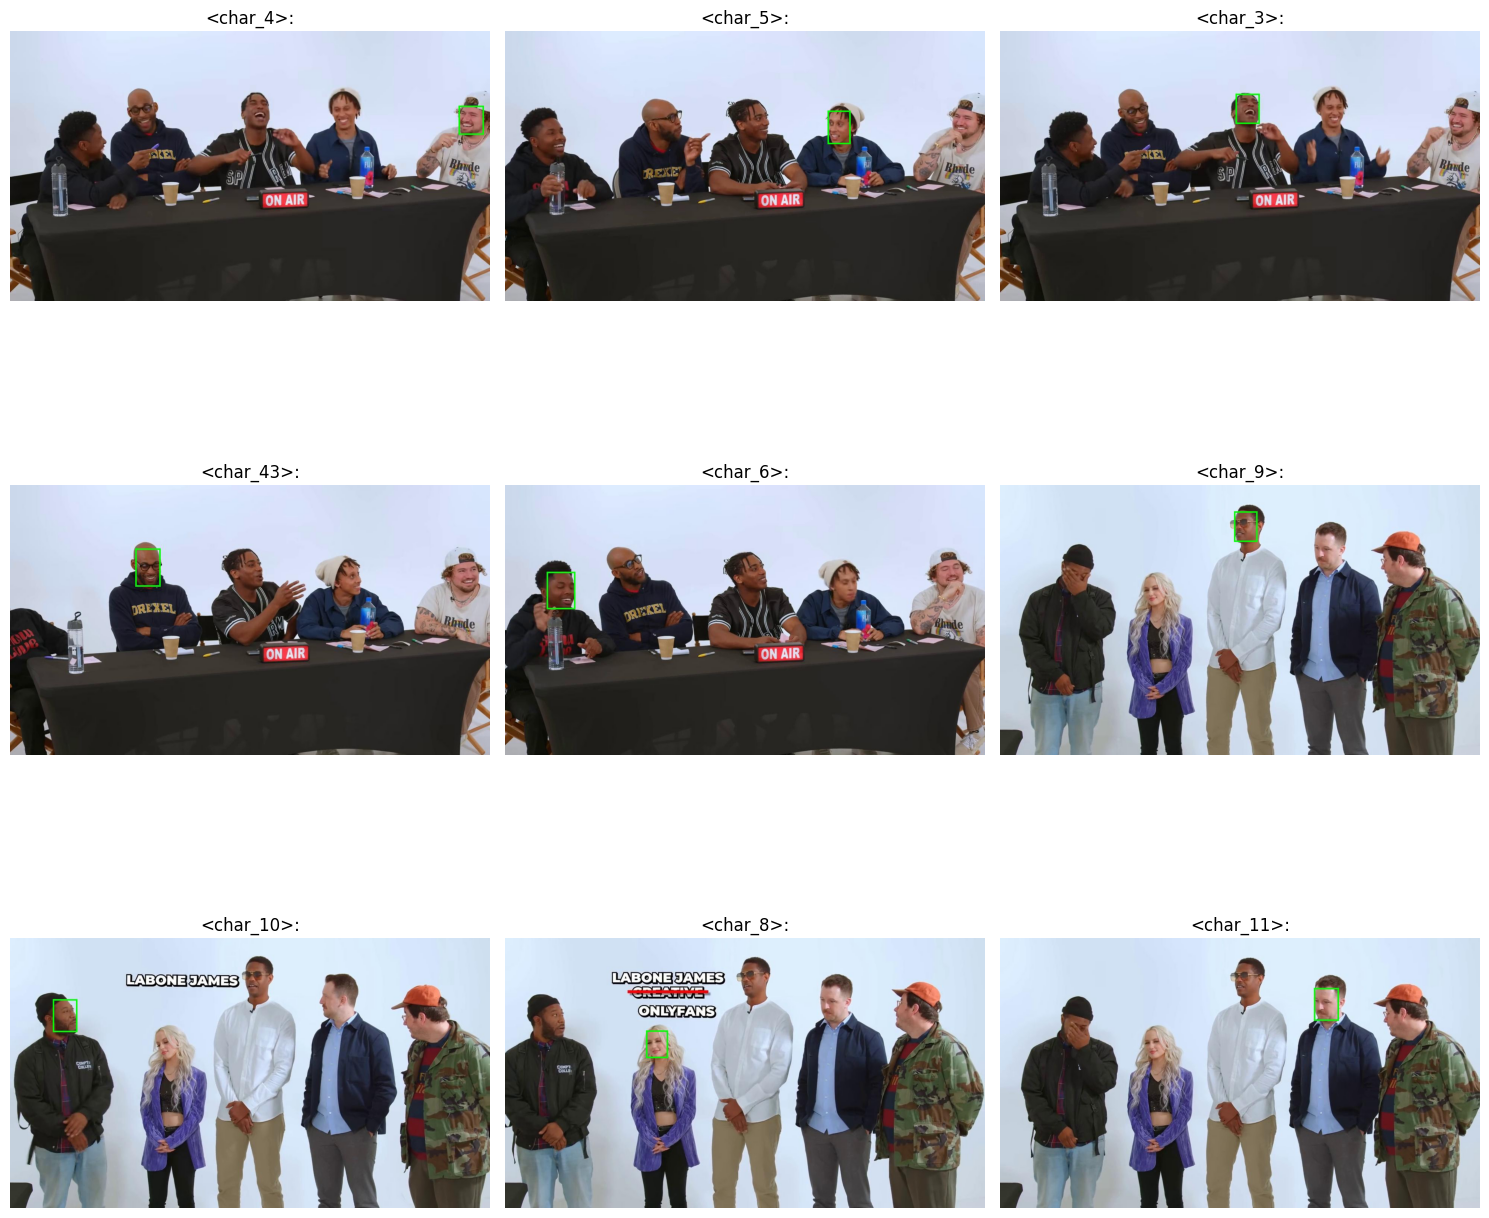

{'<speaker_0>': [{'start_time': '00:03', 'end_time': '00:05', 'content': 'What do you do for a living, Labone?'}, {'start_time': '00:20', 'end_time': '00:22', 'content': 'Number four, what is your name and what do you do for a living?'}], '<speaker_121>': [{'start_time': '00:05', 'end_time': '00:08', 'content': "Uh, I'm a creative."}, {'start_time': '00:13', 'end_time': '00:16', 'content': "Yeah, yeah, it's, uh, my OnlyFans handle, so."}], '<speaker_149>': [{'start_time': '00:08', 'end_time': '00:10', 'content': 'Okay. He might be nice.'}], '<speaker_150>': [{'start_time': '00:17', 'end_time': '00:19', 'content': "We might have a millionaire. I don't even know."}], '<speaker_151>': [{'start_time': '00:22', 'end_time': '00:26', 'content': 'Uh, my name is Stuart Thompson, and I am a professor.'}]}
Generating captions 0 times


2025-03-25 05:09:08,173 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


Generating thinkings 0 times


2025-03-25 05:09:14,212 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/multimodal/crawl/openai/deployments/gemini-1.5-pro-002/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


['<char_4> wears a white t-shirt and a white baseball cap.', '<char_4> puts his hand to his face as he laughs.', '<char_5> wears a blue denim jacket and a white knit cap.', '<char_5> looks toward <char_3> with a surprised facial expression.', '<char_3> wears a white and black baseball-style shirt.', '<char_3> puts his head down on the table and laughs.', '<char_43> wears glasses and a navy blue Drexel University sweatshirt.', '<char_43> raises his hands and gestures as if in surprise.', '<char_6> wears a black hoodie.', '<char_6> holds a water bottle in his right hand.', '<char_9> wears a white long-sleeved button-down shirt and aviator sunglasses.', "<char_9> says: 'Uh, I'm a creative.'", '<char_10> wears a black jacket and light blue jeans.', '<char_10> covers his face with his hands.', '<char_8> wears a purple jacket and black pants.', '<char_8> clasps her hands in front of her.', '<char_11> wears a dark blue button-down shirt and gray pants.', "<char_11> says: 'Uh, my name is Stuar

In [3]:
video_graph = VideoGraph()
# video_path = "/mnt/bn/videonasi18n/longlin.kylin/vlm-agent-benchmarking/data/videos/raw/720p/5 Poor People vs 1 Secret Millionaire.mp4"
video_path = "data/videos/clipped/5 Poor People vs 1 Secret Millionaire"

streaming_process_video(
    video_graph, video_path, interval_seconds=60, fps=5, segment_limit=5
)

In [4]:
print(len(video_graph.text_nodes))
print(video_graph.edges)
print(video_graph.nodes)

162
{(12, 6): 1.0, (6, 12): 1.0, (13, 6): 1.0, (6, 13): 1.0, (14, 7): 1.0, (7, 14): 1.0, (15, 7): 1.0, (7, 15): 1.0, (16, 3): 1.0, (3, 16): 1.0, (17, 3): 1.0, (3, 17): 1.0, (18, 5): 1.0, (5, 18): 1.0, (19, 5): 1.0, (5, 19): 1.0, (20, 4): 1.0, (4, 20): 1.0, (21, 4): 1.0, (4, 21): 1.0, (22, 10): 1.0, (10, 22): 1.0, (23, 10): 1.0, (10, 23): 1.0, (24, 1): 1.0, (1, 24): 1.0, (24, 10): 1.0, (10, 24): 1.0, (25, 9): 1.0, (9, 25): 1.0, (26, 9): 1.0, (9, 26): 1.0, (27, 8): 1.0, (8, 27): 1.0, (28, 8): 1.0, (8, 28): 1.0, (29, 11): 1.0, (11, 29): 1.0, (30, 11): 1.0, (11, 30): 1.0, (31, 2): 1.0, (2, 31): 1.0, (31, 3): 1.0, (3, 31): 1.0, (32, 2): 1.0, (2, 32): 1.0, (32, 3): 1.0, (3, 32): 1.0, (33, 2): 1.0, (2, 33): 1.0, (33, 3): 1.0, (3, 33): 1.0, (34, 1): 1.0, (1, 34): 1.0, (34, 10): 1.0, (10, 34): 1.0, (35, 6): 1.0, (6, 35): 1.0, (35, 0): 1.0, (0, 35): 1.0, (36, 3): 1.0, (3, 36): 1.0, (36, 2): 1.0, (2, 36): 1.0, (37, 10): 1.0, (10, 37): 1.0, (37, 1): 1.0, (1, 37): 1.0, (38, 3): 1.0, (3, 38): 1.0, (

In [5]:
# from retrieve import retrieve_from_videograph
from videograph import VideoGraph
from utils.chat_api import (
    generate_messages,
    get_response_with_retry,
    parallel_get_embedding,
)
from utils.general import validate_and_fix_python_list
from prompts import prompt_memory_retrieval

MAX_RETRIES = 3


def generate_queries(question, existing_knowledge=None, query_num=1):
    input = [
        {
            "type": "text",
            "content": prompt_memory_retrieval.format(
                question=question,
                query_num=query_num,
                existing_knowledge=existing_knowledge,
            ),
        }
    ]
    messages = generate_messages(input)
    model = "gpt-4o-2024-11-20"
    queries = None
    for i in range(MAX_RETRIES):
        print(f"Generating queries {i} times")
        queries = get_response_with_retry(model, messages)[0]
        queries = validate_and_fix_python_list(queries)
        if queries is not None:
            break
    if queries is None:
        raise Exception("Failed to generate queries")
    return queries


def retrieve_from_videograph(videograph, question, topk=3):
    queries = generate_queries(question)
    print(f"Queries: {queries}")

    model = "text-embedding-3-large"
    query_embeddings = parallel_get_embedding(model, queries)[0]

    related_nodes = []

    for query_embedding in query_embeddings:
        nodes = videograph.search_text_nodes(query_embedding)
        related_nodes.extend(nodes)

    related_nodes = list(set(related_nodes))
    return related_nodes

question = "Denny"
retrieved_nodes = retrieve_from_videograph(video_graph, question)
print(retrieved_nodes)

Generating queries 0 times


2025-03-25 05:09:15,943 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


Queries: ['Background and characteristics of Denny']
[]
